# IIC-2433 Minería de Datos UC

- Versiones de librerías, python 3.8.10

- numpy 1.20.3
- sklearn 1.0.2
- matplotlib 3.5.2

In [1]:
from sklearn.datasets import fetch_covtype
covtype = fetch_covtype()
print(covtype.data.shape)

(581012, 54)


In [2]:
import random
random_numbers = random.sample(range(covtype.data.shape[0]), 10000)
sample = covtype.data[random_numbers,:]


## Actividad en clase

Clusterice el dataset usando **Kmeans**. Para esto haga lo siguiente:

- Preprocese los datos y reduzca la dimensionalidad del sample de manera que retenga el 90% de la varianza. 
- Corra kmeans con inicialización random para valores de k en el rango [5, 6, 7, 8, 9, 10]. 
- Determine el mejor valor de k según el Silhouette score promedio. 
- ¿Cuál valor de k usaría?
- Sobre el dataset PCa a 90%, elimine outliers en base al histograma de LOFs. Justifique el umbral de corte.
- Elimine los outliers del dataset.
- Corra kmeans con inicialización random para valores de k en el rango [5, 6, 7, 8, 9, 10]. 
- Determine el mejor valor de k según el Silhouette score promedio. 
- ¿Cuál valor de k usaría?
- ¿Qué cambió al eliminar los outliers?
- Cuanto termine, me avisa para entregarle una **L (logrado)**.
- Recuerde que las L otorgan un bono en la nota final de la asignatura.
- Pueden trabajar de a dos.

***Tiene hasta el final de la clase.***

In [3]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
X = min_max_scaler.fit_transform(sample)

In [4]:
from sklearn.decomposition import PCA

def min_var(v,exp_var):
    acc = 0
    i=0
    while acc < v:
        acc += exp_var[i]
        i += 1
    return i

In [5]:
pca = PCA(n_components=50)
pca.fit(X)
min_var(0.9,pca.explained_variance_ratio_)

20

In [6]:
pca = PCA(n_components=20)
X= pca.fit_transform(X)

Para k= 5 Silhouette score promedio: 0.2698062566646508
Para k= 6 Silhouette score promedio: 0.24379250053199547
Para k= 7 Silhouette score promedio: 0.2861990626617841
Para k= 8 Silhouette score promedio: 0.35070849787973385
Para k= 9 Silhouette score promedio: 0.3294804545628924
Para k= 10 Silhouette score promedio: 0.3524184938837681


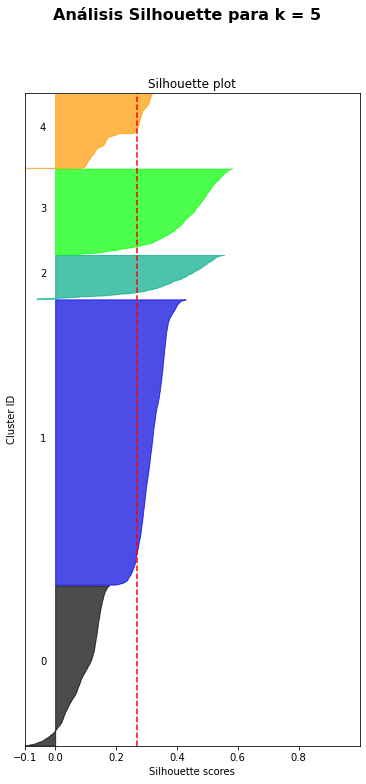

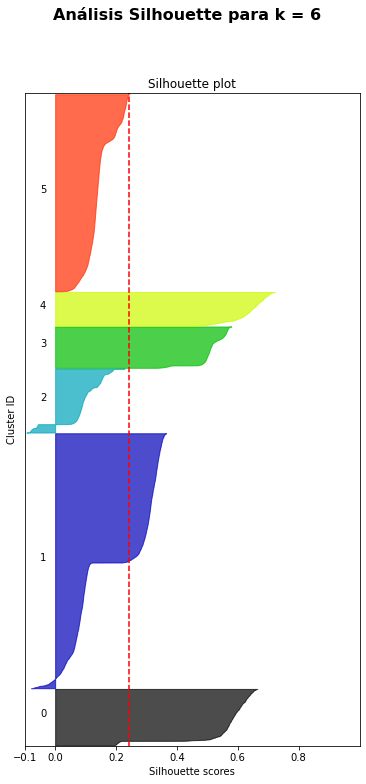

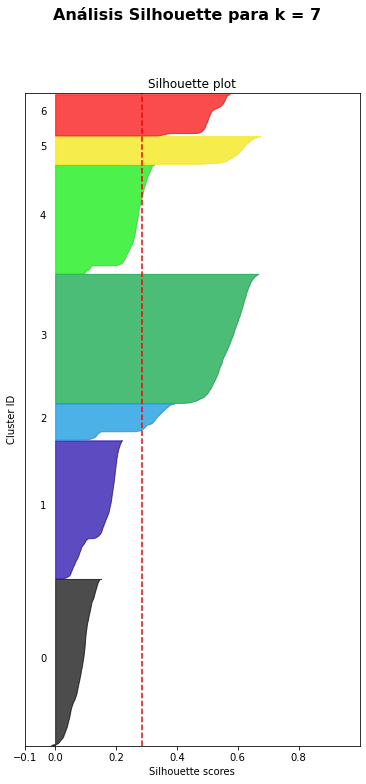

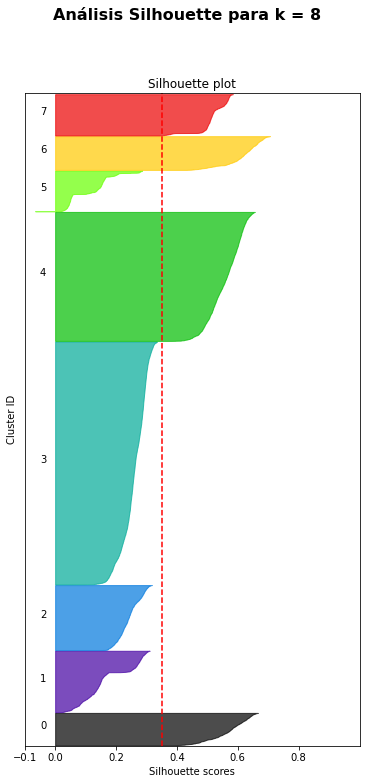

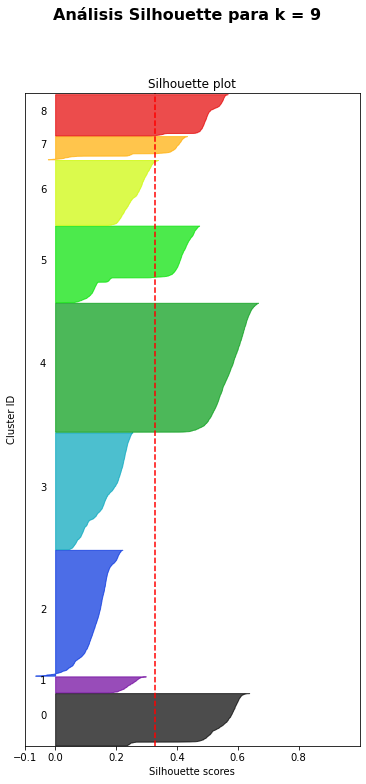

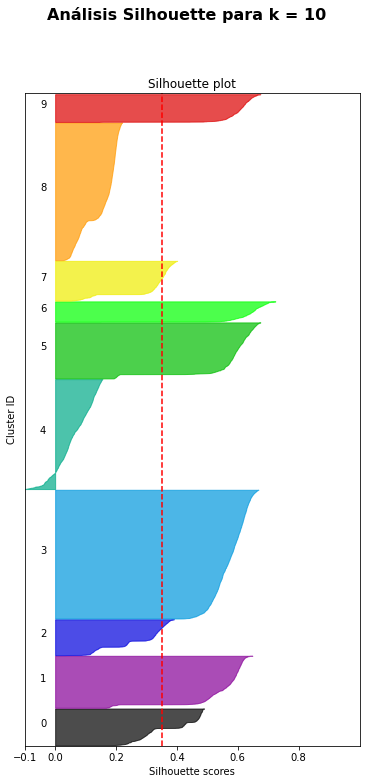

In [7]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler

range_n_clusters = [5, 6, 7, 8, 9, 10]

for n_clusters in range_n_clusters:
    fig, ax = plt.subplots(figsize=(6, 12))
    ax.set_xlim([-0.1, 1])
    ax.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    kmeans = KMeans(init="random", n_clusters=n_clusters, n_init=4)
    estimator = make_pipeline(MinMaxScaler(), kmeans).fit(X)
    cluster_labels = estimator.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "Para k=",
        n_clusters,
        "Silhouette score promedio:",
        silhouette_avg,
    )

    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))


        y_lower = y_upper + 10  

    ax.set_title("Silhouette plot")
    ax.set_xlabel("Silhouette scores")
    ax.set_ylabel("Cluster ID")
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8])


    plt.suptitle(
        "Análisis Silhouette para k = %d"
        % n_clusters,
        fontsize=16,
        fontweight="bold",
    )

plt.show()

In [8]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(n_neighbors=5, metric='euclidean')
lof.fit_predict(X)
scores = lof.negative_outlier_factor_

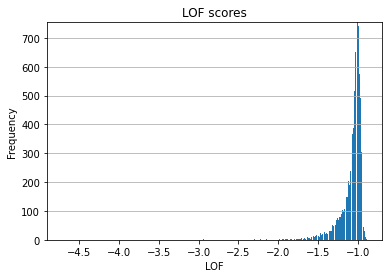

In [9]:
import numpy as np
import matplotlib.pyplot as plt

def plot_hist(X, title):
    x, bins, patches = plt.hist(x=X, bins='auto', rwidth=0.85)
    plt.grid(axis='y')
    plt.xlabel('LOF')
    plt.ylabel('Frequency')
    plt.title(title)
    maxfreq = x.max()
    plt.ylim(ymax=np.ceil(maxfreq))


plot_hist(scores, 'LOF scores')

In [11]:
def lof_threshold(v,scores):
    N = len(scores)
    points = scores[scores < v]
    threshold = len(points)/N
    return threshold

lof_threshold(-1.5,scores)

0.0236

In [12]:
lof = LocalOutlierFactor(n_neighbors=5, metric='euclidean', contamination=0.0236)
labels = lof.fit_predict(X)

In [13]:
indices = list(np.where(labels==1)[0])

In [14]:
X = X[indices,:] 

Para k= 5 Silhouette score promedio: 0.29876102256676884
Para k= 6 Silhouette score promedio: 0.24649104685477224
Para k= 7 Silhouette score promedio: 0.3456876561360368
Para k= 8 Silhouette score promedio: 0.2891595707839055
Para k= 9 Silhouette score promedio: 0.3143016730475701
Para k= 10 Silhouette score promedio: 0.37642746302947055


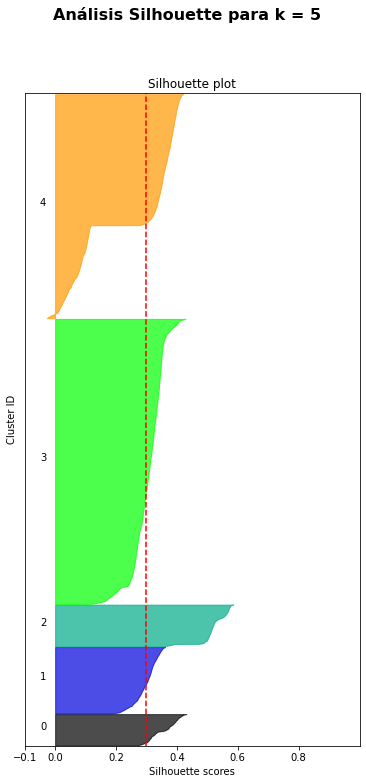

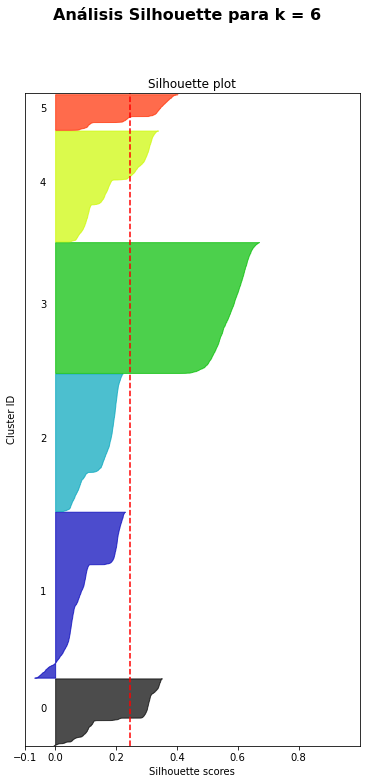

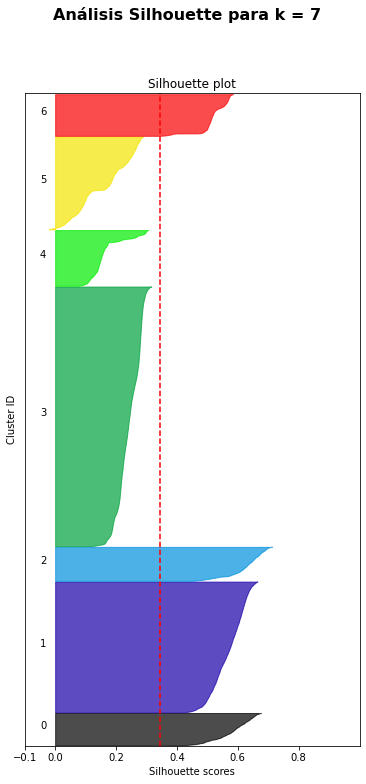

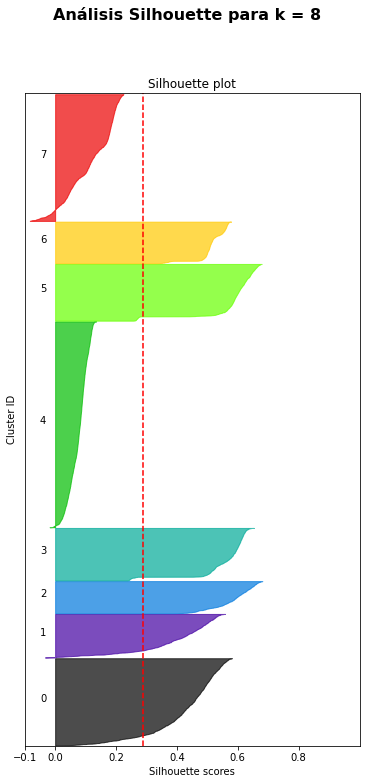

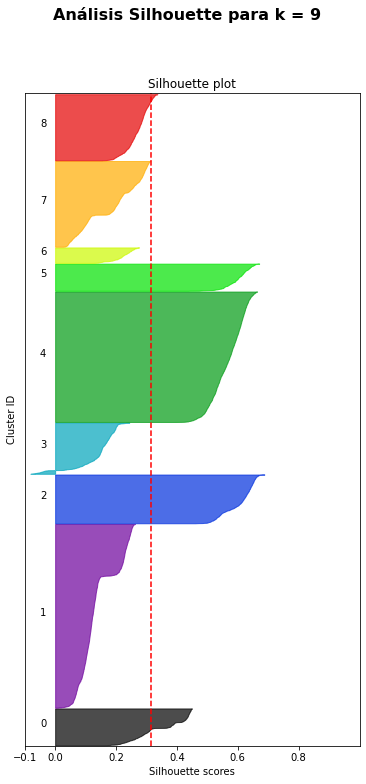

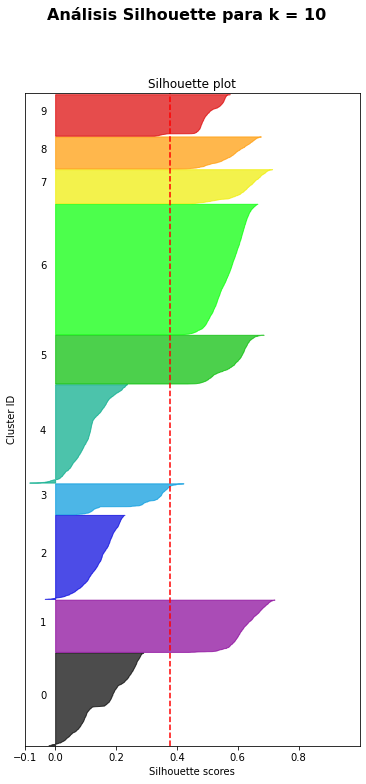

In [15]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler

range_n_clusters = [5, 6, 7, 8, 9, 10]

for n_clusters in range_n_clusters:
    fig, ax = plt.subplots(figsize=(6, 12))
    ax.set_xlim([-0.1, 1])
    ax.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    kmeans = KMeans(init="random", n_clusters=n_clusters, n_init=4)
    estimator = make_pipeline(MinMaxScaler(), kmeans).fit(X)
    cluster_labels = estimator.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "Para k=",
        n_clusters,
        "Silhouette score promedio:",
        silhouette_avg,
    )

    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))


        y_lower = y_upper + 10  

    ax.set_title("Silhouette plot")
    ax.set_xlabel("Silhouette scores")
    ax.set_ylabel("Cluster ID")
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8])


    plt.suptitle(
        "Análisis Silhouette para k = %d"
        % n_clusters,
        fontsize=16,
        fontweight="bold",
    )

plt.show()

### El Silhouette score a k=10 mejoró al eliminar outliers